In [1]:
import numpy as np
import os
import random
from tqdm import tqdm

folder = '/beagle3/dinner/zpengmei/insulin/feats_reduced'

# Function to process each file
def process_file(filename):
    data = np.load(filename, mmap_mode='r')
    try:
        # Directly index the memory-mapped array to only read every 5th frame
        # Avoid reshaping the entire array, instead, slice directly into the required dimensions
        # The original shape should be known: (4000, 102, 256)
        # Access every 5th frame directly: slice from start to end, stepping by 5
        feature = data['features_masked']
        return feature
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None
    finally:
        data.close()

# Listing files
traj_list = [f for f in os.listdir(folder) if f.endswith('.npz')]
# random.shuffle(traj_list)

# Use list comprehension to construct the list, handling files where data is correctly processed
data_list = [feature for traj in tqdm(traj_list) if (feature := process_file(os.path.join(folder, traj))) is not None]

# Now data_list contains all the processed arrays.
print(f"Processed {len(data_list)} files.")




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 781/781 [02:05<00:00,  6.22it/s]

Processed 781 files.


In [1]:
import numpy as np
import os
import random
from tqdm import tqdm

folder = '/beagle3/dinner/zpengmei/insulin/feats'
target_folder = '/beagle3/dinner/zpengmei/insulin/feats_reduced'

# read filenames in the target folder to avoid reprocessing
processed_files = os.listdir(target_folder)
print(processed_files)

['concat_s16i19.dcd.npz', 'concat_s18i18.dcd.npz', 'concat_s00i02.dcd.npz', 'concat_s18i27.dcd.npz', 'concat_s23i10.dcd.npz', 'concat_s20i20.dcd.npz', 'concat_s05i11.dcd.npz', 'concat_s27i23.dcd.npz', 'concat_s15i05.dcd.npz', 'concat_s17i20.dcd.npz', 'concat_s27i04.dcd.npz', 'concat_s23i17.dcd.npz', 'concat_s23i07.dcd.npz', 'concat_s09i05.dcd.npz', 'concat_s01i06.dcd.npz', 'concat_s13i15.dcd.npz', 'concat_s07i16.dcd.npz', 'concat_s18i06.dcd.npz', 'concat_s20i04.dcd.npz', 'concat_s26i07.dcd.npz', 'concat_s03i20.dcd.npz', 'concat_s11i09.dcd.npz', 'concat_s06i04.dcd.npz', 'concat_s09i10.dcd.npz', 'concat_s21i01.dcd.npz', 'concat_s02i16.dcd.npz', 'concat_s24i14.dcd.npz', 'concat_s03i22.dcd.npz', 'concat_s04i24.dcd.npz', 'concat_s13i10.dcd.npz', 'concat_s26i05.dcd.npz', 'concat_s12i18.dcd.npz', 'concat_s14i11.dcd.npz', 'concat_s03i00.dcd.npz', 'concat_s23i27.dcd.npz', 'concat_s18i12.dcd.npz', 'concat_s14i23.dcd.npz', 'concat_s02i03.dcd.npz', 'concat_s21i25.dcd.npz', 'concat_s15i11.dcd.npz',

In [2]:
import numpy as np
import os
import random
from tqdm import tqdm

folder = '/beagle3/dinner/zpengmei/insulin/feats'
target_folder = '/beagle3/dinner/zpengmei/insulin/feats_reduced'

# read filenames in the target folder to avoid reprocessing
processed_files = os.listdir(target_folder)


# Function to process each file
def process_file(filename):

    data = np.load(filename, mmap_mode='r')
    try:
        # Directly index the memory-mapped array to only read every 5th frame
        # Avoid reshaping the entire array, instead, slice directly into the required dimensions
        # The original shape should be known: (4000, 102, 256)
        # Access every 5th frame directly: slice from start to end, stepping by 5
        feature = data['features_masked'][0,::5, :, :]
        traj_name = data['traj_file']
        traj_name = str(traj_name)
        traj_name = traj_name.split('/')
        traj_name = '/'.join(traj_name[-1:])
        # store the reduced data
        np.savez(os.path.join(target_folder, traj_name), features_masked=feature)
        # return feature
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None
    finally:
        data.close()

# Listing files
traj_list = [f for f in os.listdir(folder) if f.endswith('.npz')]
random.shuffle(traj_list)

# Use list comprehension to construct the list, handling files where data is correctly processed
data_list = [feature for traj in tqdm(traj_list) if (feature := process_file(os.path.join(folder, traj))) is not None]

# Now data_list contains all the processed arrays.
print(f"Processed {len(data_list)} files.")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 781/781 [09:42<00:00,  1.34it/s]

Processed 0 files.


In [5]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from ssp.modules.models.representation_models.visnet import EquivariantScalar

class CustomTransformerEncoderLayer(TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                            key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights

class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.num_layers = num_layers

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src
        attention_weights = []

        for layer in self.layers:
            output, attn_weights = layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
            attention_weights.append(attn_weights)

        return output, attention_weights


class SubFormer_VAMP(nn.Module):

    def __init__(self,hidden_channels, atom_emb_dim, graph_emb_dim, encoder_layers, nhead, dim_feedforward, dropout=0.1):
        super(SubFormer_VAMP, self).__init__()

        # self.atom_projection = EquivariantScalar(hidden_channels, atom_emb_dim)

        ## transformer encoder
        encoder_layer = CustomTransformerEncoderLayer(batch_first=True,
                                                 d_model=atom_emb_dim,
                                                 nhead=nhead, 
                                                 dim_feedforward=dim_feedforward, 
                                                 dropout=dropout)

        self.transformer_encoder = CustomTransformerEncoder(encoder_layer, num_layers=encoder_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, atom_emb_dim))
        ##
        self.norm1 = nn.BatchNorm1d(atom_emb_dim)
        self.graph_projection = nn.Sequential(
            nn.Linear(atom_emb_dim, atom_emb_dim),
            nn.SiLU(),
            nn.Linear(atom_emb_dim, graph_emb_dim)
        )

        self.activation = nn.SiLU()

        self.feat_dim = atom_emb_dim
    
    def get_weights(self,data):
        graph_emb = data
        src = torch.cat((self.cls_token.expand(graph_emb.size(0), -1, -1), graph_emb), dim=1)
        src, attention_weights = self.transformer_encoder(src, src_key_padding_mask=None)
        return attention_weights
    

    def forward(self, data):

        graph_emb = data
        src = torch.cat((self.cls_token.expand(graph_emb.size(0), -1, -1), graph_emb), dim=1)
        src, attention_weights = self.transformer_encoder(src, src_key_padding_mask=None)
        graph_emb = src[:,0,:]
        graph_emb = self.graph_projection(graph_emb)

        return graph_emb

In [5]:
from graphvampnets.processing.dataprocessing import Preprocessing, Postprocessing_vamp
from graphvampnets.utils import set_random_seed, ContourPlot2D
import numpy as np
import torch 
from tqdm import *

pre = Preprocessing()
dataset = pre.create_dataset(data_list,lag_time=10)

val = int(len(dataset)*0.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

val_data = torch.utils.data.Subset(val_data, range(0, 5000))

print("Train data: ", len(train_data))
print("Validation data: ", len(val_data))

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
print(device)

Train data:  555291
Validation data:  5000
cuda


In [6]:
from graphvampnets.vamp.vampnet import VAMPNet
from torch.utils.data.dataloader import DataLoader
from graphvampnets.layers.vismodel import GraphVAMPNetLayerPost

loader_train = DataLoader(train_data, batch_size=500, shuffle=True)
loader_val = DataLoader(val_data, batch_size=500, shuffle=False)

torch.set_float32_matmul_precision('high')

lobe = SubFormer_VAMP(128, 256, 5, 6, 8, 256,0.1)
# compile the model
# lobe = torch.compile(lobe)

lobe = lobe.to(device)
from copy import deepcopy
lobe_lagged = deepcopy(lobe).to(device=device)
net = VAMPNet(lobe=lobe, lobe_lagged=lobe_lagged, learning_rate=5e-4, device=device)
net.fit(loader_train, n_epochs=5,
                    validation_loader=loader_val, progress=tqdm)

epoch:  20%|███████████████████████▏                                                                                            | 1/5 [07:00<28:03, 420.94s/it]

0 4.011450290679932


epoch:  40%|██████████████████████████████████████████████▍                                                                     | 2/5 [13:58<20:57, 419.04s/it]

1 4.35809850692749


epoch:  60%|█████████████████████████████████████████████████████████████████████▌                                              | 3/5 [20:48<13:49, 414.70s/it]

2 4.342668056488037


epoch:  80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4/5 [27:45<06:55, 415.81s/it]

3 4.394123077392578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1111/1111 [06:48<00:00,  2.72it/s]
                                                                                                                                                               

4 4.492313861846924


In [7]:
# save the model
import torch
torch.save(lobe.state_dict(), '/project/dinner/zpengmei/insulin/lobe.pth')
torch.save(lobe_lagged.state_dict(), '/project/dinner/zpengmei/insulin/lobe_lagged.pth')

In [7]:
from graphvampnets.vamp.vampnet import VAMPNet
from torch.utils.data.dataloader import DataLoader
from graphvampnets.layers.vismodel import GraphVAMPNetLayerPost
import torch

torch.set_float32_matmul_precision('high')

lobe = SubFormer_VAMP(128, 256, 5, 6, 8, 256,0.1)
# compile the model
# lobe = torch.compile(lobe)
device = torch.device("cuda")

lobe = lobe.to(device)
from copy import deepcopy
lobe_lagged = deepcopy(lobe).to(device=device)
# load the model
lobe.load_state_dict(torch.load('/project/dinner/zpengmei/insulin/lobe.pth'))
lobe_lagged.load_state_dict(torch.load('/project/dinner/zpengmei/insulin/lobe_lagged.pth'))
net = VAMPNet(lobe=lobe, lobe_lagged=lobe_lagged, learning_rate=5e-4, device=device)


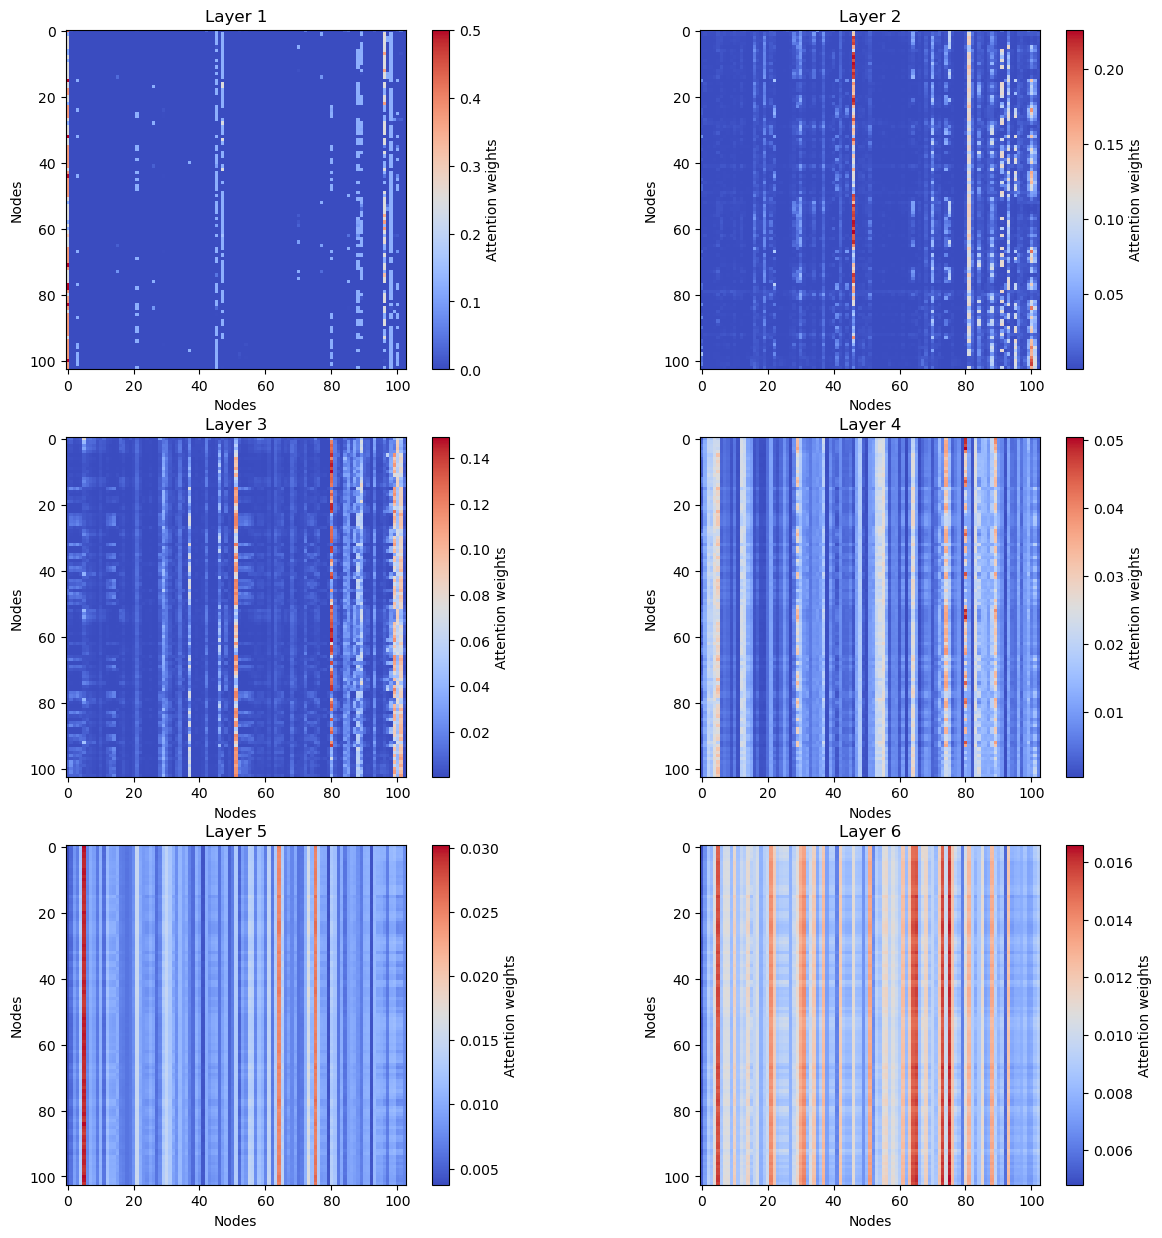

In [8]:
# show the attention weights from 6 layers using plt heat map in subplots
attn_weights = lobe.get_weights(torch.from_numpy(data_list[-1][5:20]).to(device))
attn_weights = torch.stack(attn_weights, dim=0)
attn_weights_sample = attn_weights[:,0,:200,:200].cpu().detach().numpy()

import matplotlib.pyplot as plt


fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for i in range(6):
    axs[i//2,i%2].imshow(attn_weights_sample[i],cmap='coolwarm', interpolation='nearest')
    axs[i//2,i%2].set_title(f'Layer {i+1}')
    # color bar
    cbar = plt.colorbar(axs[i//2,i%2].imshow(attn_weights_sample[i],cmap='coolwarm', interpolation='nearest'), ax=axs[i//2,i%2])
    cbar.set_label('Attention weights')
    axs[i//2,i%2].set_xlabel('Nodes')
    axs[i//2,i%2].set_ylabel('Nodes')

# overall title
plt.show()


    

In [ ]:
graphvampnets_cvs = net.transform(data_list,return_cv=True,lag_time=50,batch_size=100)


Text(0, 0.5, 'Time scales (10 ps)')

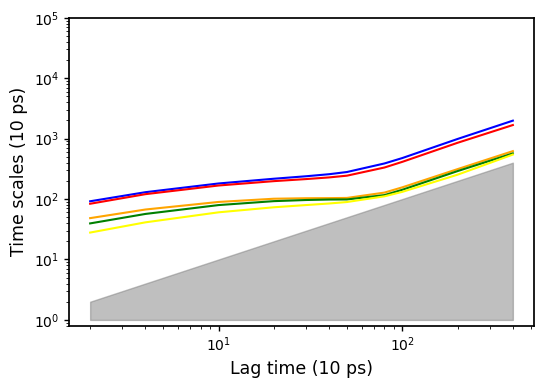

In [9]:
from graphvampnets.processing.dataprocessing import Preprocessing, Postprocessing_vamp

# graphvampnets_cvs = np.concatenate(graph_cvs,axis=0)

its = []
lag_times = [1,2,5,10,15,20,25,40,50,100,200]
for lagt in lag_times:
    post = Postprocessing_vamp(n_dims=5,lag_time=np.int64(lagt),dtype=np.float64)
    its.append(post.fit(graphvampnets_cvs).time_scales)
its = np.array(its)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['axes.linewidth']=1.25
### One frame interval equals to 2 ps
plt.loglog(np.array(lag_times)*2,its[:,0]*2,linewidth=1.5,c='blue')
plt.loglog(np.array(lag_times)*2,its[:,1]*2,linewidth=1.5,c='red')
plt.loglog(np.array(lag_times)*2,its[:,2]*2,linewidth=1.5,c='orange')
plt.loglog(np.array(lag_times)*2,its[:,3]*2,linewidth=1.5,c='green')
plt.semilogy(np.array(lag_times)*2,its[:,4]*2,linewidth=1.5,c='yellow')
plt.ylim(0.8,100000)
plt.fill_between(np.array(lag_times)*2,np.ones(len(lag_times)),np.array(lag_times)*2,color='grey',alpha=0.5)
plt.tick_params(axis="both",labelsize=10,direction='out',length=3.75,width=1)
plt.xlabel('Lag time (10 ps)',fontsize=12.5)
plt.ylabel('Time scales (10 ps)',fontsize=12.5)

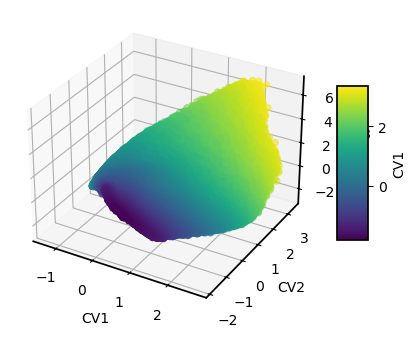

In [10]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming g is your dataset with columns or CV1, CV2, and Z
g = np.concatenate(graphvampnets_cvs, axis=0)
# g = graphvampnets_cvs
X = g[:, 0]
Y = g[:, 1]
Z = g[:, 2]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X, Y, Z, c=Y, cmap='viridis', marker='o')

ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_zlabel('CV3')

# Adding a color bar to represent the values of Z
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('CV1')

plt.show()

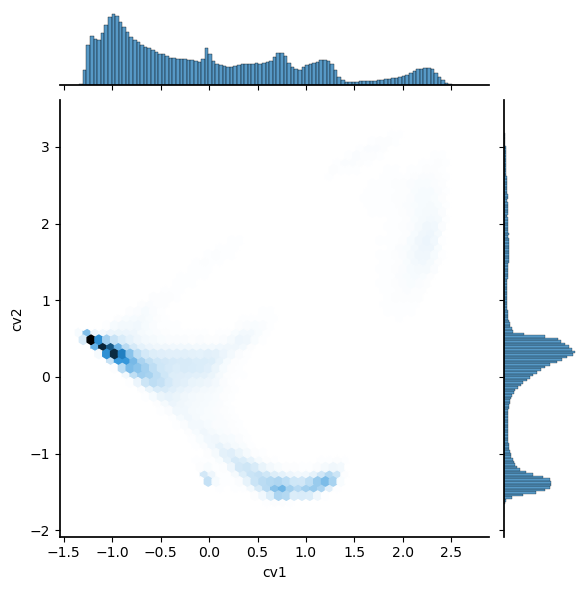

In [11]:
# scatter plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(g[:,0:2],columns=['cv1','cv2'])
sns.jointplot(data=df,x='cv1',y='cv2',kind='hex')
plt.show()

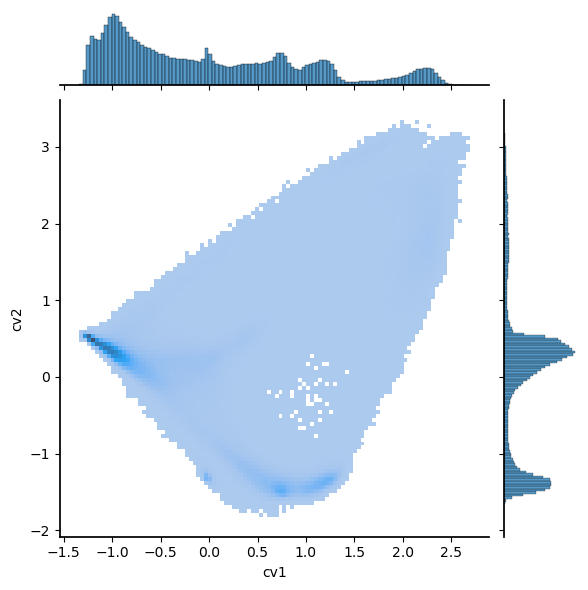

In [12]:
# histgram 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(g[:,0:2],columns=['cv1','cv2'])
sns.jointplot(data=df,x='cv1',y='cv2',kind='hist',bins=100)
plt.show()

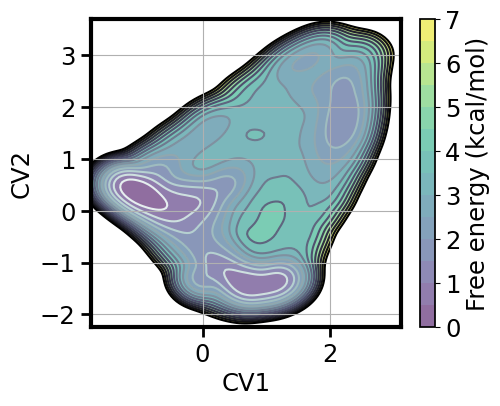

In [14]:
from matplotlib import pyplot as plt
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(5,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,0:2][::5],ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')

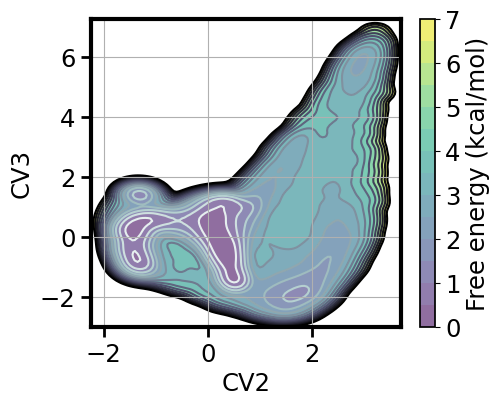

In [24]:
from matplotlib import pyplot as plt
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(5,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,1:3][::5],ax,labelsize=17.5,xlabel='CV2',ylabel='CV3')

In [17]:
g.shape

(624800, 5)

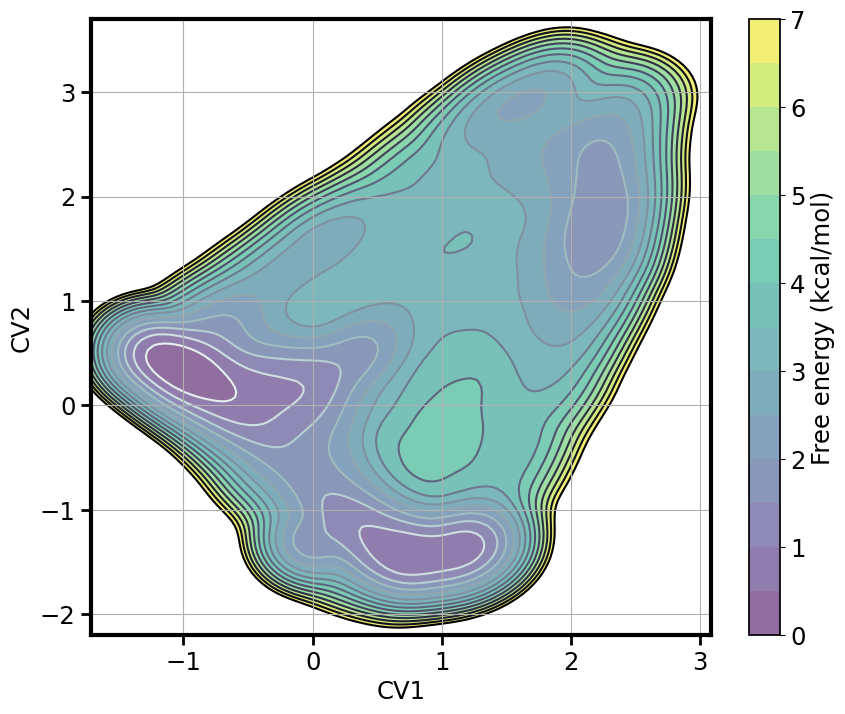

In [14]:
from matplotlib import pyplot as plt
from graphvampnets.utils import set_random_seed, ContourPlot2D

# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(10,8))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,0:2][::3],ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')

In [22]:
# find the indices of the point based on the CVs
import numpy as np

# cv1 [0.5,1]. cv2 [-1.5,-1.2]
cv1 = g[:,0]
cv2 = g[:,1]

idx = np.where((cv1>0.5) & (cv1<1) & (cv2>-1.5) & (cv2<-1.2))[0]


In [24]:
idx[0:100]

array([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  27,  29,
        30,  31,  32,  33,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  88,  89,  91,  93,  97,  99, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131,
       132, 133, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 266, 279, 280, 281])

/project/dinner/zpengmei/subspace_pytorch/graphvampnets/utils.py:113: RuntimeWarning: divide by zero encountered in log
  return - THERMO_CONSTANT * temperature * np.log(z)


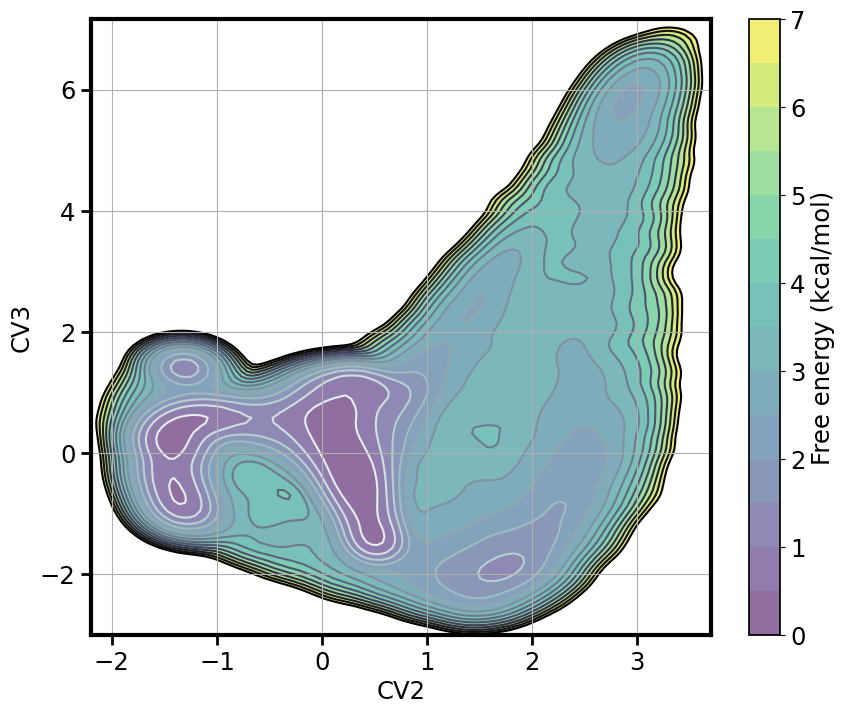

In [15]:
from matplotlib import pyplot as plt
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(10,8))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,1:3][::3],ax,labelsize=17.5,xlabel='CV2',ylabel='CV3')

In [16]:
# save the cv
np.save('/project/dinner/zpengmei/insulin/graphvampnets_cvs.npy',graphvampnets_cvs)

In [9]:
# load the data
import numpy as np

folder = '/project/dinner/zpengmei/insulin/features'

data_list = []
# loop over the folder ends with .npz 
import os
traj_list = [f for f in os.listdir(folder) if f.endswith('.npz')]
# random shuffle the traj_list using python random.shuffle
import random
random.shuffle(traj_list)
print(traj_list)

for traj in traj_list:
    data = np.load(f'{folder}/{traj}')
    feature = data['features_masked'][::2].sum(2)
    if feature.shape[1] ==6000:
        continue
    # squeeze the first dimension
    feature = np.squeeze(feature)
    print(feature.shape)
    data_list.append(feature)


['ET_features_32.npz', 'ET_features_7.npz', 'ET_features_270.npz', 'ET_features_139.npz', 'ET_features_292.npz', 'ET_features_0.npz', 'ET_features_148.npz', 'ET_features_6.npz', 'ET_features_2.npz', 'ET_features_287.npz', 'ET_features_295.npz', 'ET_features_133.npz', 'ET_features_264.npz', 'ET_features_142.npz', 'ET_features_144.npz', 'ET_features_39.npz', 'ET_features_274.npz', 'ET_features_301.npz', 'ET_features_283.npz', 'ET_features_149.npz', 'ET_features_30.npz', 'ET_features_22.npz', 'ET_features_277.npz', 'ET_features_143.npz', 'ET_features_5.npz', 'ET_features_298.npz', 'ET_features_290.npz', 'ET_features_273.npz', 'ET_features_146.npz', 'ET_features_38.npz', 'ET_features_267.npz', 'ET_features_282.npz', 'ET_features_12.npz', 'ET_features_268.npz', 'ET_features_19.npz', 'ET_features_271.npz', 'ET_features_34.npz', 'ET_features_281.npz', 'ET_features_152.npz', 'ET_features_3.npz', 'ET_features_269.npz', 'ET_features_296.npz', 'ET_features_157.npz', 'ET_features_33.npz', 'ET_feat

In [10]:
feature.shape

(4000, 256)

In [11]:
import numpy as np
import torch 
from tqdm import *

from graphvampnets.processing.dataprocessing import Preprocessing, Postprocessing_vamp
from graphvampnets.processing.graphloader import GraphPairLoader
from graphvampnets.vamp.vampnet import VAMPNet
from graphvampnets.utils import set_random_seed, ContourPlot2D

pre = Preprocessing()
dataset = pre.create_dataset(data_list,lag_time=50)

val = int(len(dataset)*0.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

val_data = torch.utils.data.Subset(val_data, range(0, 1000))

print("Train data: ", len(train_data))
print("Validation data: ", len(val_data))

# shape of the input data
train_data[0][0].shape

Train data:  287955
Validation data:  1000


(256,)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
print(device)

cuda


In [17]:
import torch
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
from torch.utils.data.dataloader import DataLoader
from graphvampnets.layers.vismodel import GraphVAMPNetLayerPost

loader_train = DataLoader(train_data, batch_size=500, shuffle=True)
loader_val = DataLoader(val_data, batch_size=500, shuffle=False)


lobe = MLP(256, 128, 5).to(device)

lobe = lobe.to(device)
from copy import deepcopy
lobe_lagged = deepcopy(lobe).to(device=device)
net = VAMPNet(lobe=lobe, lobe_lagged=lobe_lagged, learning_rate=5e-4, device=device)
net.fit(loader_train, n_epochs=20,
                    validation_loader=loader_val, progress=tqdm)


epoch:   5%|██████▋                                                                                                                               | 1/20 [00:03<01:01,  3.23s/it]

0 2.6826257705688477


epoch:  10%|█████████████▍                                                                                                                        | 2/20 [00:06<00:57,  3.21s/it]

1 2.7449934482574463


epoch:  15%|████████████████████                                                                                                                  | 3/20 [00:09<00:54,  3.20s/it]

2 2.7562408447265625


epoch:  20%|██████████████████████████▊                                                                                                           | 4/20 [00:12<00:51,  3.20s/it]

3 2.7759323120117188


epoch:  25%|█████████████████████████████████▌                                                                                                    | 5/20 [00:16<00:47,  3.20s/it]

4 2.7506580352783203


epoch:  30%|████████████████████████████████████████▏                                                                                             | 6/20 [00:19<00:44,  3.19s/it]

5 2.7791638374328613


epoch:  35%|██████████████████████████████████████████████▉                                                                                       | 7/20 [00:22<00:41,  3.20s/it]

6 2.7748594284057617


epoch:  40%|█████████████████████████████████████████████████████▌                                                                                | 8/20 [00:25<00:38,  3.20s/it]

7 2.7519538402557373


epoch:  45%|████████████████████████████████████████████████████████████▎                                                                         | 9/20 [00:28<00:35,  3.20s/it]

8 2.7780613899230957


epoch:  50%|██████████████████████████████████████████████████████████████████▌                                                                  | 10/20 [00:31<00:31,  3.20s/it]

9 2.781073808670044


epoch:  55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 11/20 [00:35<00:28,  3.19s/it]

10 2.7571821212768555


epoch:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 12/20 [00:38<00:25,  3.21s/it]

11 2.7607390880584717


epoch:  65%|██████████████████████████████████████████████████████████████████████████████████████▍                                              | 13/20 [00:41<00:22,  3.25s/it]

12 2.786130905151367


epoch:  70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 14/20 [00:45<00:19,  3.25s/it]

13 2.7845206260681152


epoch:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15/20 [00:48<00:16,  3.24s/it]

14 2.790464401245117


epoch:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16/20 [00:51<00:13,  3.28s/it]

15 2.780036449432373


epoch:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17/20 [00:54<00:09,  3.26s/it]

16 2.7797887325286865


epoch:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 18/20 [00:58<00:06,  3.25s/it]

17 2.7844982147216797


epoch:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [01:01<00:03,  3.23s/it]

18 2.788972854614258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 576/576 [00:03<00:00, 181.81it/s]
                                                                                                                                                                                 

19 2.7930808067321777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10052.26it/s]


Text(0, 0.5, 'Time scales (ps)')

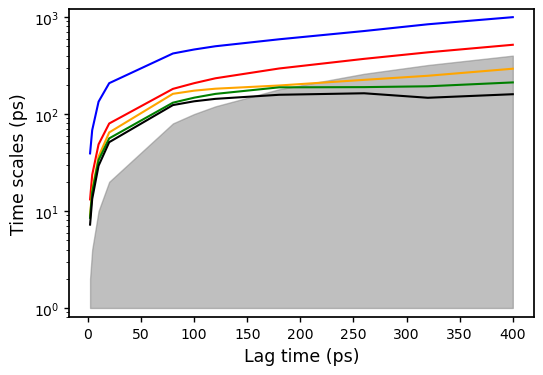

In [24]:
graphvampnets_cvs = net.transform(data_list,return_cv=True,lag_time=50,batch_size=500)
its = []
lag_times = [1,2,5,10,40,50,60,90,130,160,200]
for lagt in lag_times:
    post = Postprocessing_vamp(n_dims=5,lag_time=np.int64(lagt),dtype=np.float64)
    its.append(post.fit(graphvampnets_cvs).time_scales)
its = np.array(its)

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['axes.linewidth']=1.25
### One frame interval equals to 2 ps
plt.semilogy(np.array(lag_times)*2,its[:,0]*2,linewidth=1.5,c='blue')
plt.semilogy(np.array(lag_times)*2,its[:,1]*2,linewidth=1.5,c='red')
plt.semilogy(np.array(lag_times)*2,its[:,2]*2,linewidth=1.5,c='orange')
plt.semilogy(np.array(lag_times)*2,its[:,3]*2,linewidth=1.5,c='green')
plt.semilogy(np.array(lag_times)*2,its[:,4]*2,linewidth=1.5,c='black')
# plt.semilogy(np.array(lag_times)*2,its[:,5]*2,linewidth=1.5,c='yellow')
# plt.semilogy(np.array(lag_times)*2,its[:,6]*2,linewidth=1.5,c='cyan')
# plt.semilogy(np.array(lag_times)*2,its[:,7]*2,linewidth=1.5,c='pink')

plt.ylim(0.8,1200)
plt.fill_between(np.array(lag_times)*2,np.ones(len(lag_times)),np.array(lag_times)*2,color='grey',alpha=0.5)
plt.tick_params(axis="both",labelsize=10,direction='out',length=3.75,width=1)
plt.xlabel('Lag time (ps)',fontsize=12.5)
plt.ylabel('Time scales (ps)',fontsize=12.5)

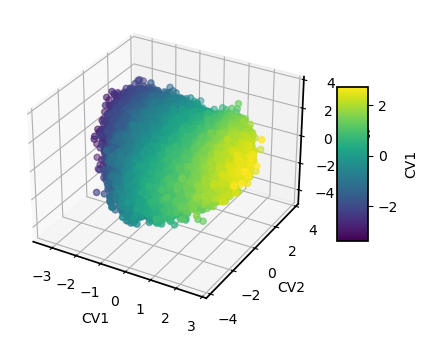

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming g is your dataset with columns or CV1, CV2, and Z
g = np.concatenate(graphvampnets_cvs, axis=0)
# g = graphvampnets_cvs
X = g[:, 0]
Y = g[:, 1]
Z = g[:, 2]

# Creating a 3D scatter plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X, Y, Z, c=X, cmap='viridis', marker='o')

ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_zlabel('CV3')

# Adding a color bar to represent the values of Z
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('CV1')

plt.show()

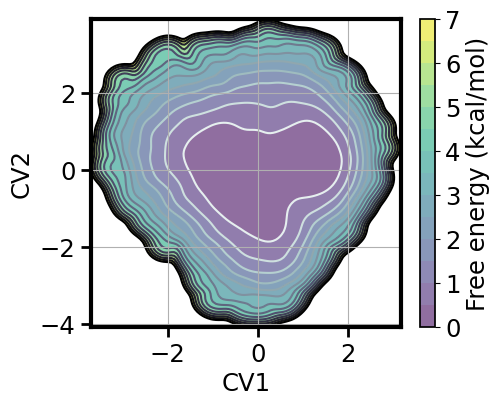

In [22]:
from matplotlib import pyplot as plt
# g = np.concatenate(graphvampnets_cvs)
fig, ax = plt.subplots(1,1,figsize=(5,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
#ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
ax.yaxis.set_tick_params(labelsize=17.5,direction='out',length=7.5,width=2)
c = ContourPlot2D()
ax = c.plot(g[:,0:2][::5],ax,labelsize=17.5,xlabel='CV1',ylabel='CV2')